In [1]:
import pandas as pd
# coding: UTF-8
import time
import torch
import warnings 
warnings.filterwarnings("ignore")
import numpy as np
import torch.utils.data as data
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import r2_score
from torch.utils.data import SubsetRandomSampler
from xgboost import XGBRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing
from units import *

### 数据预处理

In [2]:
save='./统计指标/1/'
rawdata=pd.read_excel("../backup/arousal_record.xlsx")
rawdata=rawdata[['aweme_id','collect_count','create_time','digg_count','duration','follower_count','gender','share_count','keyword','comment_get','comment_count','intention_counts','variation','arousal']]
rawdata=rawdata[rawdata['variation'].notna()]
rawdata=rawdata[rawdata['arousal'].notna()]
def keyword_encode(keyword):
    if "运动" in keyword:
        return 0
    elif "健身" in keyword:
        return 1
    elif "减肥" in keyword:
        return 2
    elif "自律" in keyword:
        return 3
rawdata['keyword']=rawdata['keyword'].apply(keyword_encode) # 非数字编码
rawdata.fillna(0) # 空值填充0
rawdata['intention_counts']=rawdata['intention_counts']/rawdata['comment_get']
rawdata.drop('comment_get',axis=1)
columns=['aweme_id','collect_count', 'create_time','duration',
       'follower_count', 'gender', 'share_count', 'keyword','comment_count',
        'variation', 'arousal' ,'V*A','digg_count', 'intention_counts']
rawdata['V*A']=rawdata['variation']*rawdata['arousal']
rawdata=rawdata[columns]
select_num=220
select_pd=pd.DataFrame()
select_pd=select_pd.append(rawdata.sort_values(by=['variation','arousal'],ascending=[False,False]).head(select_num),ignore_index=True)
select_pd=select_pd.append(rawdata.sort_values(by=['arousal','variation'],ascending=[False,False]).head(select_num),ignore_index=True)
select_pd=select_pd.append(rawdata.sort_values(by=['variation','arousal'],ascending=[True,False]).head(select_num),ignore_index=True)
select_pd=select_pd.append(rawdata.sort_values(by=['arousal','variation'],ascending=[True,False]).head(select_num),ignore_index=True)
rawdata=select_pd.drop_duplicates('aweme_id')
columns=['collect_count', 'create_time','duration',
       'follower_count', 'gender', 'share_count', 'keyword','comment_count',
        # 'variation',
        #  'arousal',
        #  'V*A',
         'digg_count', 'intention_counts']
rawdata=rawdata[columns]

### 数据归一化

In [3]:
scaler = MinMaxScaler() #实例化
rawdata = scaler.fit_transform(rawdata) #fit，在这里本质是生成min(x)和max(x)
rawdata = pd.DataFrame(rawdata,columns=columns)
rawdata=rawdata.fillna(0)

### 划分数据集

In [4]:
                                 
X_train, X_test, y_train, y_test = train_test_split(rawdata.iloc[:,:-2], rawdata.iloc[:,-2], test_size=0.20,random_state=12)
model = XGBRegressor()
model.fit(X_train,y_train)
scores = model.score(X_test,y_test)
print(scores)           
y_pred=model.predict(X_test)                              

0.5914943161703268


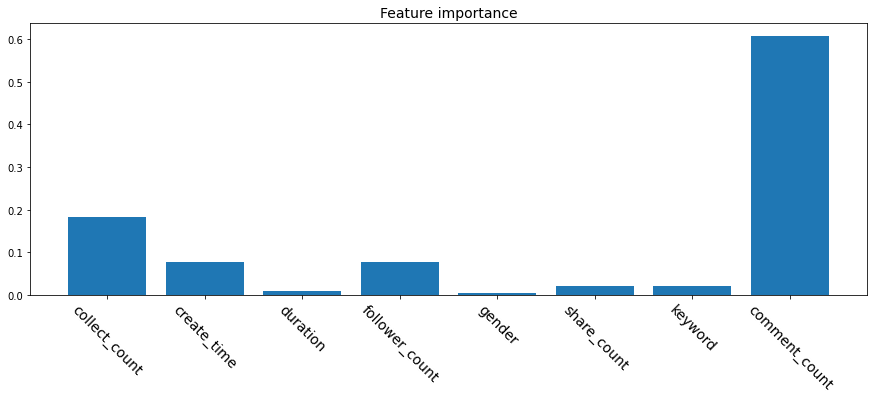

In [5]:
# 获取feature importance
import matplotlib.pyplot as plt
cols=rawdata.iloc[:,:-2].columns
plt.figure(figsize=(15, 5))
plt.bar(range(len(cols)), model.feature_importances_)
pd.DataFrame()
plt.xticks(range(len(cols)), cols, rotation=-45, fontsize=14)
plt.title('Feature importance', fontsize=14)
plt.savefig(save+'feature_importance.png')
plt.show()

In [6]:
imp=pd.DataFrame(model.feature_importances_,index=cols).T
imp

,collect_count,create_time,duration,follower_count,gender,share_count,keyword,comment_count
0,0.182063,0.076942,0.008964,0.077649,0.005454,0.020526,0.021991,0.606409


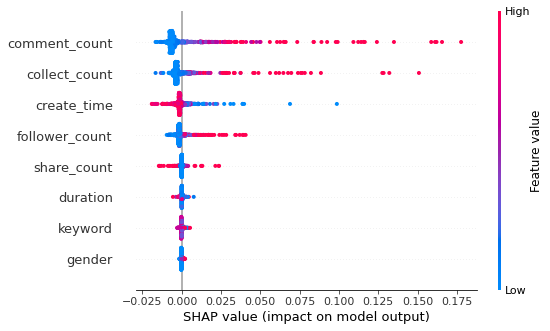

In [7]:
import shap
plt.figure(figsize=(6, 5))
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(rawdata.iloc[:,:-2][cols])
y_base = explainer.expected_value 
shap.summary_plot(shap_values, rawdata.iloc[:,:-2][cols],show=False)
plt.savefig(save+'shap.png')

In [8]:
j = len(imp)
player_explainer = pd.DataFrame()
player_explainer['feature'] = cols
player_explainer['shap_value'] = shap_values[j]
player_explainer


,feature,shap_value
0,collect_count,0.005730
1,create_time,0.013340
2,duration,-0.000176
3,follower_count,0.003028
4,gender,0.000908
5,share_count,0.001694
6,keyword,0.002240
7,comment_count,0.019668


In [9]:
player_explainer['XGB_importance']=imp.iloc[0].values
player_explainer.to_csv(save+'import_tabel.csv',index=False,encoding='utf_8_sig')
player_explainer

,feature,shap_value,XGB_importance
0,collect_count,0.005730,0.182063
1,create_time,0.013340,0.076942
2,duration,-0.000176,0.008964
3,follower_count,0.003028,0.077649
4,gender,0.000908,0.005454
5,share_count,0.001694,0.020526
6,keyword,0.002240,0.021991
7,comment_count,0.019668,0.606409


In [10]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, explained_variance_score, r2_score

y_true = y_test

mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
evs = explained_variance_score(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

metrics = {'MAE': mae, 'MSE': mse, 'RMSE': rmse, 'EVS': evs, 'R2': r2}

df = pd.DataFrame(list(metrics.items()), columns=['Metric', 'Value'])
df.to_csv(save+'Metric.csv',index=False,encoding='utf_8_sig')
print(df)

  Metric     Value
0    MAE  0.007614
1    MSE  0.002911
2   RMSE  0.053954
3    EVS  0.592842
4     R2  0.591494
